In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from pandas.api.types import is_numeric_dtype
import seaborn as sns

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
do_weighted = True

base_relevant_features = ["weighted NODF", # nestedness measures
                     "weighted connectance",
                     "modularity"] # modularity mesure, when there is only one compartment, the divsrity is nan
relevant_features = base_relevant_features+[f"null_standardized_{f}" for f in base_relevant_features] + ['number.of.species.HL']
relevant_metadata = ['is_polyploid_poly_frac', 'is_polyploid_missing_frac']
                          
network_polyploid_data_path = "../../../data/ploidy_classification/network_classification.csv"
taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/all/networks_metadata.csv"
ecoregions_metadata_path = "../../../data/metadata/network_level/ecoregions_metadata_rice_2019.xlsx"
ecoregions_polyfreq_path = "../../../data/metadata/network_level/ecoregions_polyfreq_rice_2019.xlsx"

allmb_tree_path = "../../../data/trees/ALLMB.tre"
networks_dir = "../../../data/networks/all/"
features_paths = {"binary": "../../../data/features/network/binary/features_with_classification.csv",
                  "binarized_weighted": "../../../data/features/network/binarized_weighted/features_with_classification.csv",
                  "weighted": "../../../data/features/network/weighted/features_with_classification.csv"}

processed_data_path = f"../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"

bad_binary_networks = []# [46,48,50,51,54,55,56,57,61,62,63,64,66,70,71,72,73]
bad_weighted_networks = [] #[106,107,156,157,158,159]

max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 0
min_di_threshold = 2

In [3]:
relevant_columns = ["network_id"] + relevant_features + relevant_metadata
weighted_data = pd.read_csv(features_paths["weighted"])[relevant_columns].rename(columns={"number.of.species.HL": "num_pollinators"})
if not is_numeric_dtype(weighted_data.network_id):
    weighted_data['network_id'] = weighted_data.network.str.replace(".csv","").astype("int")
weighted_data = weighted_data.loc[~weighted_data.network_id.isin(bad_weighted_networks)]
weighted_data["network_type"] = "weighted"

binarized_weighted_data = pd.read_csv(features_paths["binarized_weighted"])[relevant_columns].rename(columns={"number.of.species.HL": "num_pollinators"})
if not is_numeric_dtype(binarized_weighted_data.network_id):
    binarized_weighted_data['network_id'] = binarized_weighted_data.network.str.replace(".csv","").astype("int")
binarized_weighted_data = binarized_weighted_data.loc[~binarized_weighted_data.network_id.isin(bad_weighted_networks)]
binarized_weighted_data["network_type"] = "binarized_weighted"

binary_data = pd.read_csv(features_paths["binary"])[relevant_columns].rename(columns={"number.of.species.HL": "num_pollinators"})
if not is_numeric_dtype(binary_data.network_id):
    binary_data['network_id'] = binary_data.network.str.replace(".csv","").astype("int")
binary_data["network_type"] = "binary"  
binary_data = binary_data.loc[~binary_data.network_id.isin(bad_binary_networks)]

features = pd.concat([weighted_data,binarized_weighted_data,binary_data]).rename(columns={"number.of.species.HL": "num_pollinators",
                                                                                          "number.of.species.LL": "num_plants"})

In [4]:
features = features.drop_duplicates(["network_id", "network_type"])

In [5]:
features.groupby("network_type")["network_id"].count()

network_type
binarized_weighted    708
binary                178
weighted              704
Name: network_id, dtype: int64

In [6]:
features = features[[c for c in features.columns if not "Unnamed" in c]]

In [7]:
features.notna().sum() / features.shape[0]

network_id                                1.000000
weighted NODF                             1.000000
weighted connectance                      1.000000
modularity                                0.999371
null_standardized_weighted NODF           1.000000
null_standardized_weighted connectance    1.000000
null_standardized_modularity              0.999371
num_pollinators                           1.000000
is_polyploid_poly_frac                    1.000000
is_polyploid_missing_frac                 1.000000
network_type                              1.000000
dtype: float64

In [8]:
features = features.dropna(subset=["is_polyploid_poly_frac"])

In [9]:
clean_features = features.dropna() #.loc[features.is_polyploid_missing_frac <= missing_data_threshold]

In [10]:
if do_weighted:
    clean_features = clean_features.loc[clean_features.network_type == "weighted"]
else:
    clean_features = clean_features.loc[clean_features.network_type != "weighted"]

In [11]:
print(f"# networks = {clean_features.shape[0]:,}")

# networks = 704


In [12]:
clean_features.notna().sum() / clean_features.shape[0]

network_id                                1.0
weighted NODF                             1.0
weighted connectance                      1.0
modularity                                1.0
null_standardized_weighted NODF           1.0
null_standardized_weighted connectance    1.0
null_standardized_modularity              1.0
num_pollinators                           1.0
is_polyploid_poly_frac                    1.0
is_polyploid_missing_frac                 1.0
network_type                              1.0
dtype: float64

# compute phylogenetic diversity on remaining networks

In [13]:
tree = Tree(allmb_tree_path, format=1)
for l in tree.get_leaves():
    l.name = l.name.replace("_", " ").lower()

In [14]:
def get_phylogenetic_diveristy(network_path: str) -> float:
    try:
        network = pd.read_csv(network_path)
        plants = network.Plant.str.lower().tolist()
        plants_in_tree = set(plants) & set(tree.get_leaf_names())
        network_tree = tree.copy()
        network_tree.prune(plants_in_tree)
        phylo_divesity = np.sum([n.dist for n in network_tree.traverse()]) / len(network_tree.get_leaves())
        return phylo_divesity
    except Exception as e:
        #print(f"network_path={network_path}, error={e}")
        return np.nan

clean_features["pd"] = clean_features.parallel_apply(lambda rec: get_phylogenetic_diveristy(f"../../../data/networks/all/{rec.network_type}/{rec.network_id}.csv"), axis=1)

In [15]:
clean_features.network_id = clean_features.network_id.astype(str) + "_" + clean_features.network_type

<AxesSubplot: >

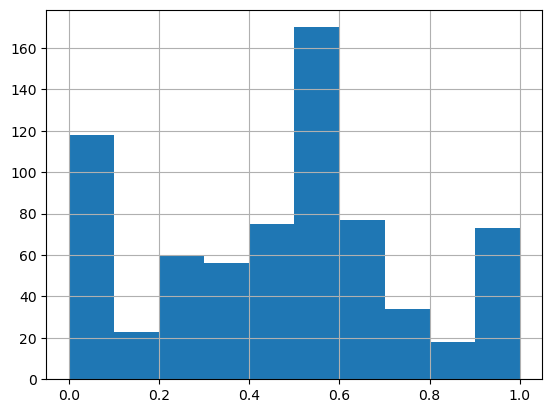

In [16]:
clean_features.is_polyploid_poly_frac.hist()

<AxesSubplot: >

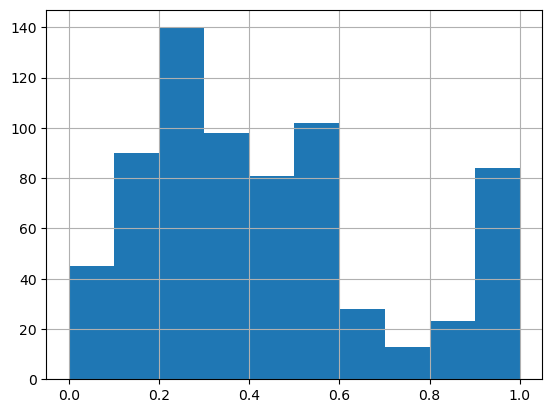

In [17]:
clean_features.is_polyploid_missing_frac.hist()

# apply box-cox transfomations on the variables to obtain a normal distribution

In [18]:
from scipy.stats import boxcox, shapiro

In [19]:
for f in base_relevant_features:
    data = clean_features[f"null_standardized_{f}"]
    pos_transfromed_data = data+abs(data.min())+0.0001
    res = boxcox(pos_transfromed_data)
    bc_transformed = res[0]
    clean_features[f"bc_transformed_{f}"] = list(bc_transformed)
    
    test1 = shapiro(clean_features[f"null_standardized_{f}"])
    test2 = shapiro(clean_features[f"bc_transformed_{f}"])
    print(f"\n\nfeature={f}\nshapiro result following delta transfromation = {test1}")
    print(f"\nshapiro result following box-cox+delta transfromation = {test2}")



feature=weighted NODF
shapiro result following delta transfromation = ShapiroResult(statistic=0.9470975399017334, pvalue=3.609733819227292e-15)

shapiro result following box-cox+delta transfromation = ShapiroResult(statistic=0.9637020230293274, pvalue=3.410604697967612e-12)


feature=weighted connectance
shapiro result following delta transfromation = ShapiroResult(statistic=0.9932031631469727, pvalue=0.0027760828379541636)

shapiro result following box-cox+delta transfromation = ShapiroResult(statistic=0.9933438897132874, pvalue=0.003243769286200404)


feature=modularity
shapiro result following delta transfromation = ShapiroResult(statistic=0.9856704473495483, pvalue=2.1819510038767476e-06)

shapiro result following box-cox+delta transfromation = ShapiroResult(statistic=0.9895042777061462, pvalue=6.31787333986722e-05)


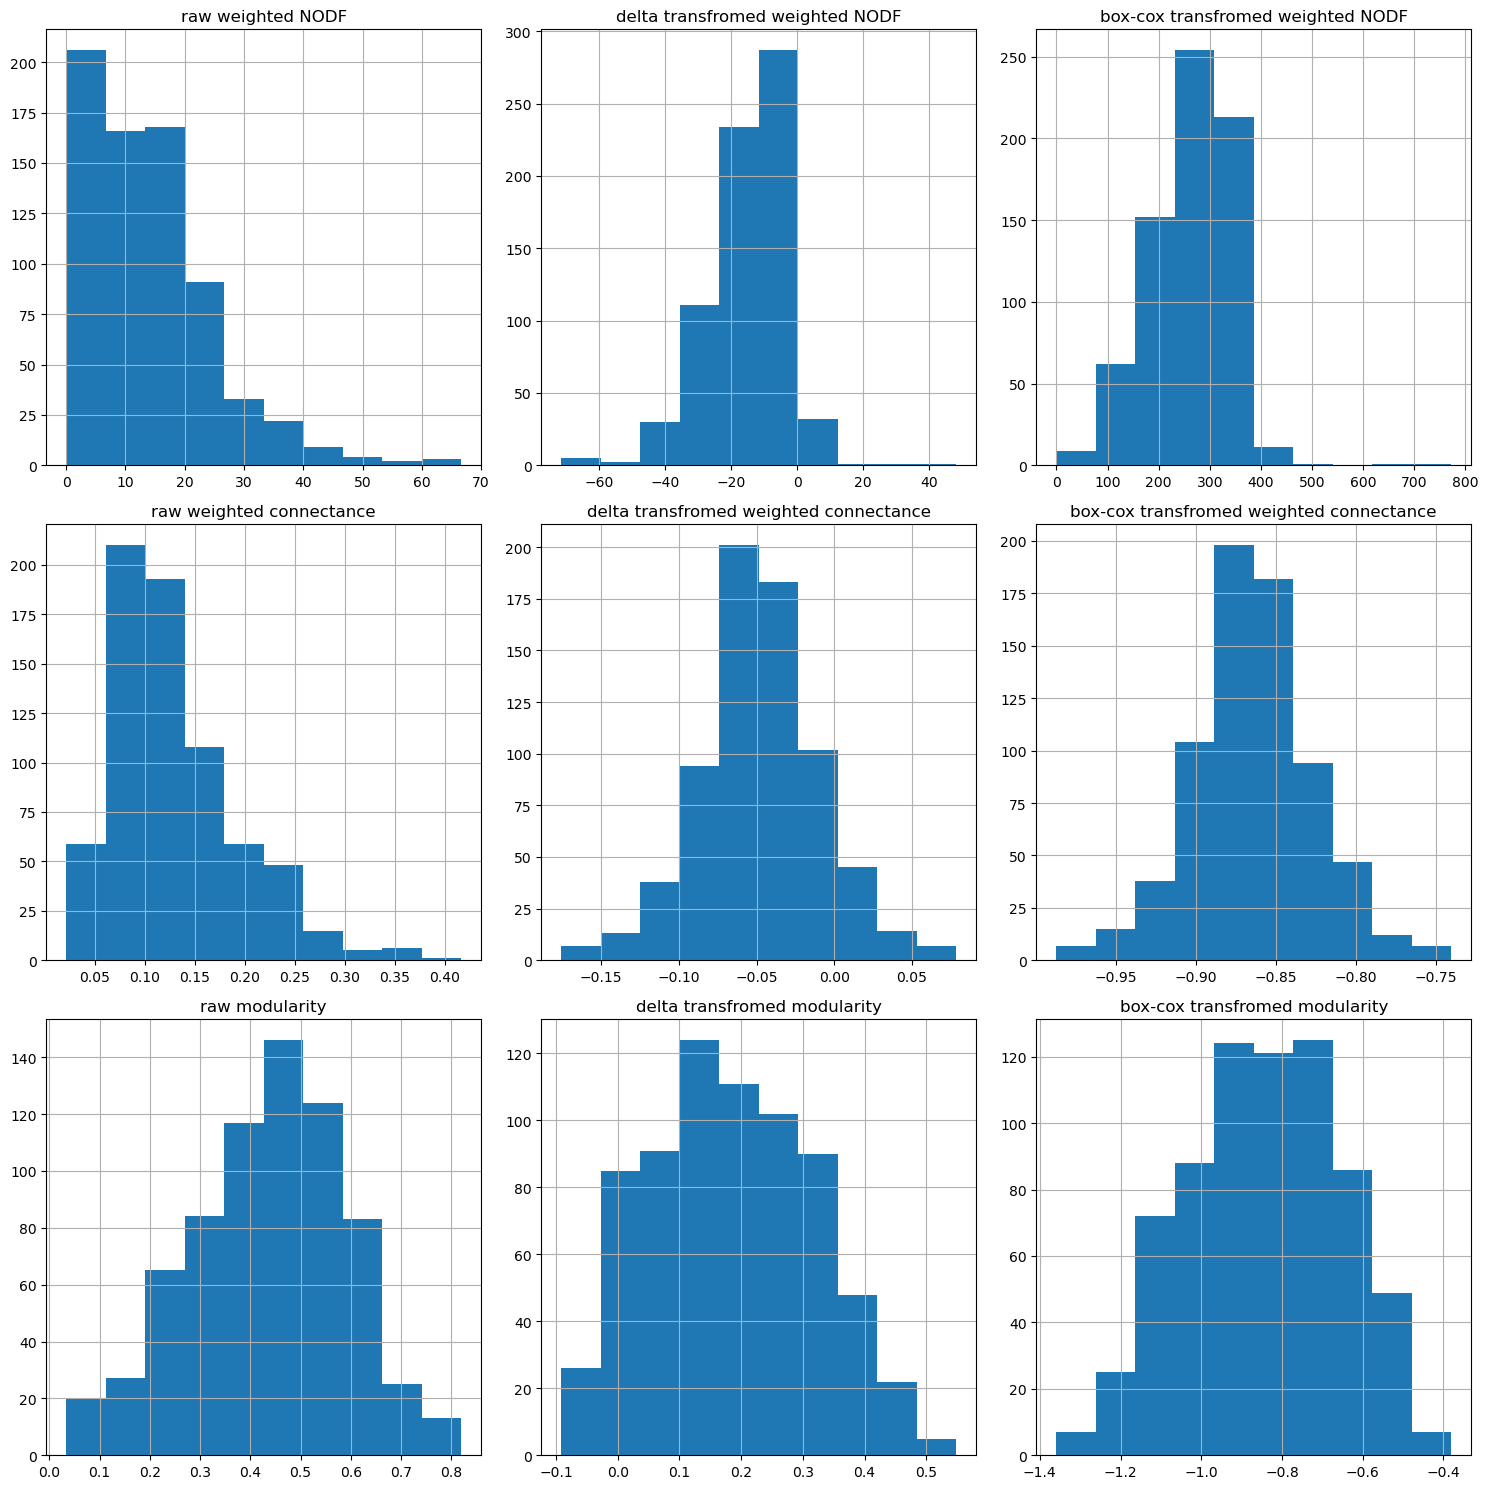

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=len(base_relevant_features), ncols=3, figsize=(3*5, len(base_relevant_features)*5))

for i in range(len(base_relevant_features)):
    f = base_relevant_features[i]
    ax0, ax1, ax2 = ax[i][0], ax[i][1], ax[i][2]
    clean_features[f"{f}"].hist(ax=ax0)
    ax0.set_title(f"raw {f}")
    clean_features[f"null_standardized_{f}"].hist(ax=ax1)
    ax1.set_title(f"delta transfromed {f}")
    clean_features[f"bc_transformed_{f}"].hist(ax=ax2)
    ax2.set_title(f"box-cox transfromed {f}")
    
fig.tight_layout()

# save data

In [21]:
relevant_features = base_relevant_features + [f"null_standardized_{f}" for f in base_relevant_features] #+ [f"bc_transformed_{f}" for f in base_relevant_features] 

In [22]:
clean_features = clean_features.drop_duplicates()
clean_features = clean_features.dropna(subset=relevant_features)
clean_features = clean_features.fillna(-1)
print(f"# remaining records = {clean_features.shape[0]:,}")
clean_features.to_csv(processed_data_path)

# remaining records = 704


# merge with bioclimate conditions, recoregion and species richness networks for which the geographic location and bioclimatic info is available

In [23]:
networks_metadata = pd.read_csv(networks_metadata_path)
networks_metadata_rel_cols = ["EcoRegion", "EcoRegion_name", "Longitude", "Latitude", "location", "path",
                              "Climate_PC1", "Climate_PC2", "Climate_PC3",
                              "Species richness", 'Perennial herb %', "Polyploid percent", "highest_pollinator_rank_index",
                              'num_plants','num_resolved','num_classified','num_polyploids','num_diploids']


clean_features = pd.read_csv(processed_data_path)
clean_features = clean_features[[c for c in clean_features.columns if not "Unnamed" in c]]
clean_features["network_index"] = clean_features.network_id.apply(lambda x: int(x.split("_")[0]))

In [24]:
clean_features = clean_features.merge(networks_metadata[["network_index", "network_type"] + networks_metadata_rel_cols], on=["network_type", "network_index"], how="left")

In [25]:
clean_features = clean_features.rename(columns={c: c.replace("_y","") for c in clean_features.columns if c.endswith("_y")}).drop([c for c in clean_features.columns if c.endswith("_x")], axis=1)

In [26]:
clean_features[networks_metadata_rel_cols].notna().sum()

EcoRegion                        411
EcoRegion_name                   650
Longitude                        578
Latitude                         650
location                         411
path                             704
Climate_PC1                      549
Climate_PC2                      549
Climate_PC3                      549
Species richness                 549
Perennial herb %                 549
Polyploid percent                549
highest_pollinator_rank_index    669
num_plants                       704
num_resolved                     704
num_classified                   704
num_polyploids                   704
num_diploids                     704
dtype: int64

In [27]:
clean_features = clean_features.drop_duplicates("network_id", keep="first")
clean_features["network_size"] = clean_features["num_plants"] * clean_features["num_pollinators"]
relevant_clean_features = clean_features.dropna(subset=networks_metadata_rel_cols)
print(f"# networks with available geodata = {relevant_clean_features.shape[0]:,}")
clean_features.to_csv(processed_data_path, index=False)

# networks with available geodata = 224


In [28]:
clean_features["path"] = clean_features.apply(lambda rec: networks_metadata.loc[(networks_metadata.network_index == rec.network_index) & (networks_metadata.network_type == rec.network_type)].path.values[0], axis=1)

In [29]:
# check how many of the networks with medata can be included in the analysis
clean_features["included_in_analysis"] = clean_features.apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and rec.num_classified >= min_classified_threshold and rec.num_polyploids >= min_poly_threhold and rec.num_diploids >= min_di_threshold, axis=1)
relevant_networks = clean_features.query("included_in_analysis")
print(f"# networks relevant for analysis = {relevant_networks.shape[0]:,}")
only_networks_metadata_rel_cols = list(set(networks_metadata_rel_cols)-{"EcoRegion", "EcoRegion_name", "Longitude", "Latitude", "location"})
with_geo_relevant_networks = relevant_networks.dropna(subset=only_networks_metadata_rel_cols)
print(f"# networks relevant for analysis with metadata = {with_geo_relevant_networks.shape[0]:,}")

# networks relevant for analysis = 323
# networks relevant for analysis with metadata = 273


In [30]:
networks_metadata = pd.read_csv(networks_metadata_path)

In [31]:
metadata_cols = set(clean_features.columns)-set(networks_metadata.columns) - {'bc_transformed_modularity',
                                                                 'bc_transformed_weighted NODF',
                                                                 'bc_transformed_weighted connectance',
                                                                 'modularity',
                                                                 'network_id',
                                                                 'null_standardized_modularity',
                                                                 'null_standardized_weighted NODF',
                                                                 'null_standardized_weighted connectance',
                                                                 'weighted NODF',
                                                                 'weighted connectance'}

In [32]:
if len(metadata_cols) > 0:
    networks_metadata = networks_metadata.merge(clean_features[["EcoRegion_name"] + list(metadata_cols)], on="EcoRegion_name", how="left")

In [33]:
cols_to_del = [c for c in networks_metadata.columns if "Unnamed" in c]
if len(cols_to_del) > 0:
        networks_metadata = networks_metadata.drop(cols_to_del, axis=1)
networks_metadata.to_csv(networks_metadata_path,index=False)

# plot data

In [34]:
clean_features = pd.read_csv(processed_data_path)

In [35]:
clean_features = clean_features.loc[(clean_features.is_polyploid_missing_frac <= max_missing_threshold) &
                                    (clean_features.num_classified >= min_classified_threshold) &
                                    (clean_features.num_polyploids >= min_poly_threhold) &
                                    (clean_features.num_diploids >= min_di_threshold)] 
print(f"# networks for analysis = {clean_features.shape[0]:,}")

# networks for analysis = 323


/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


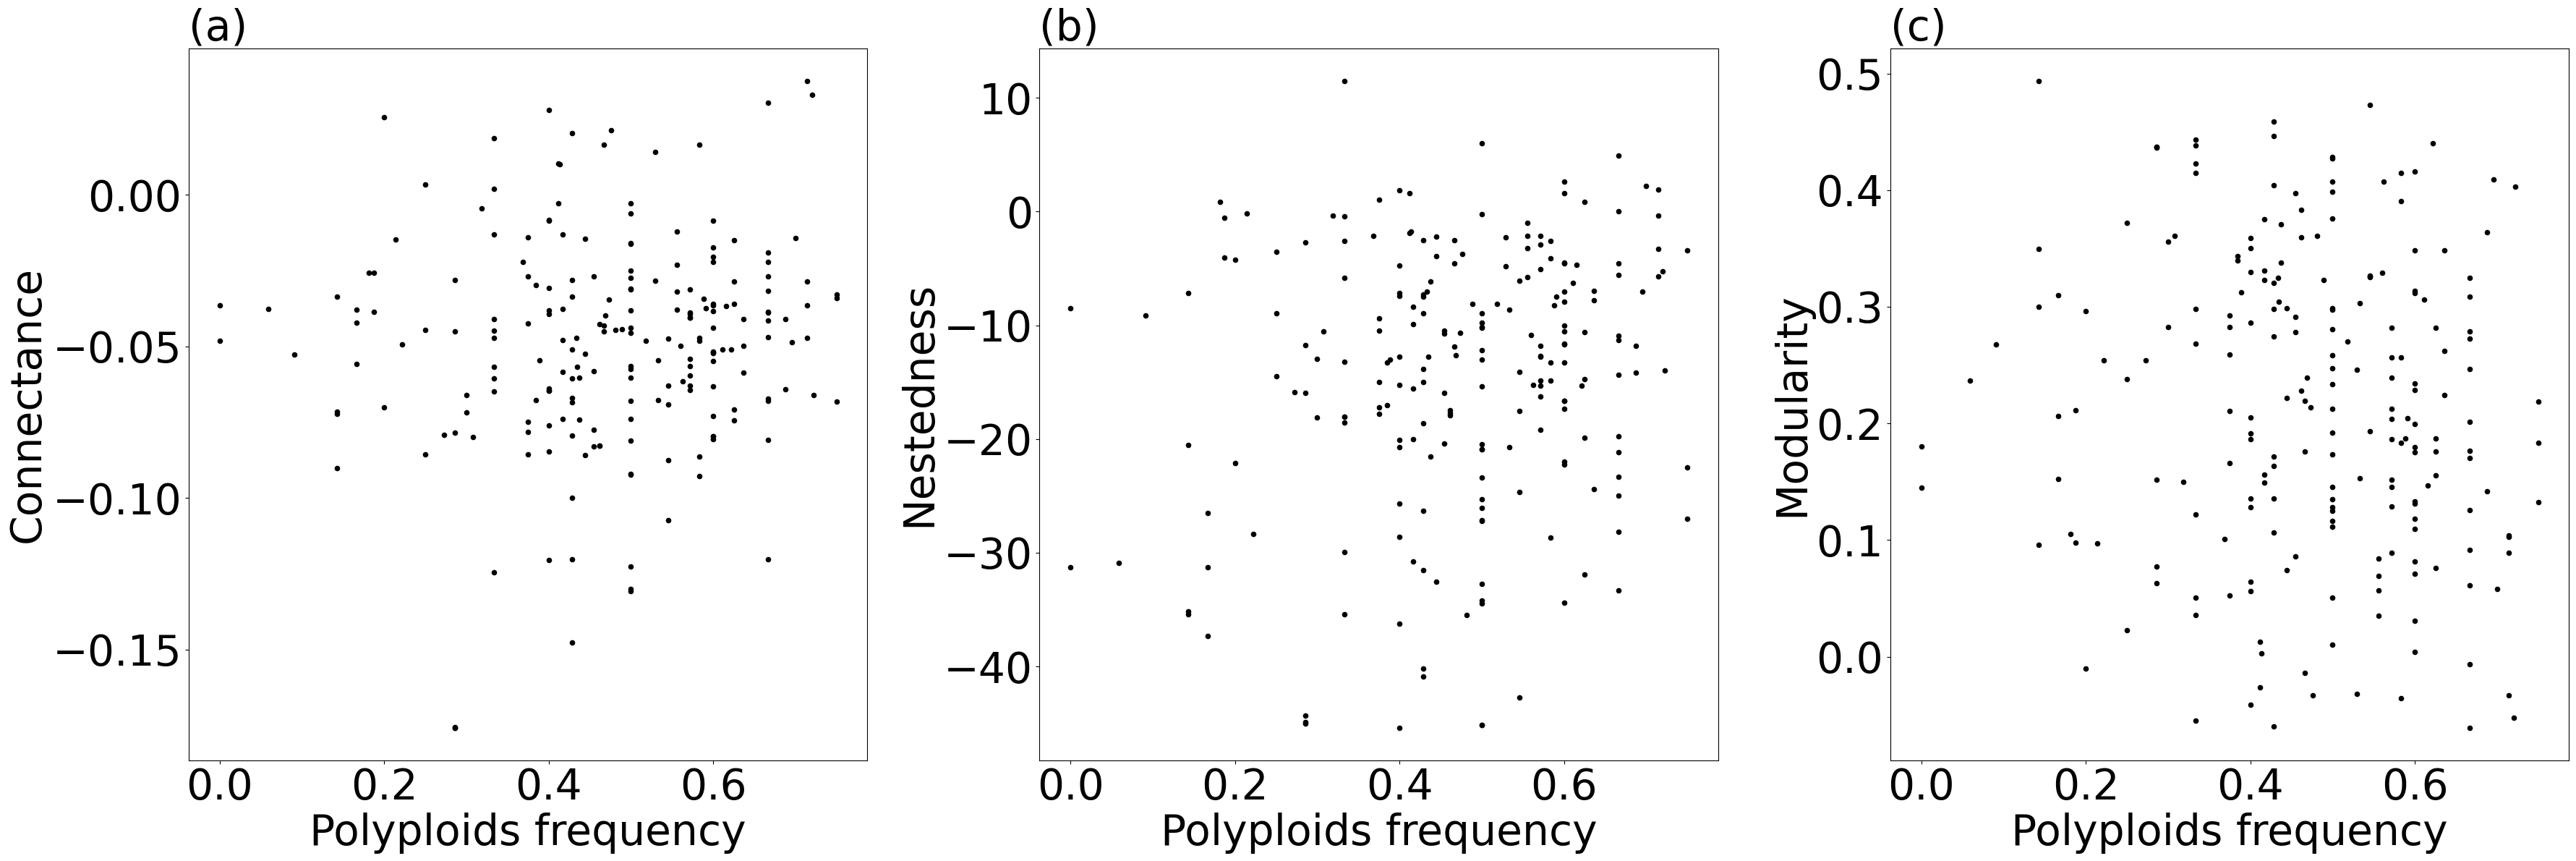

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42

plotting_features = clean_features#.loc[(clean_features.is_polyploid_missing_frac <= missing_data_threshold) & (clean_features.num_classified >= n_classified_threshold)]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*12, 1*12))
plotting_features = clean_features.loc[clean_features.is_polyploid_missing_frac <= 0.3]

ax1 = ax[0]
ax1.set_title("(a)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_weighted connectance", ax=ax1, color="black")
ax1.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax1.set_ylabel("Connectance", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)


ax2 = ax[1]
ax2.set_title("(b)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_weighted NODF", ax=ax2, color="black")
ax2.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax2.set_ylabel("Nestedness", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)


ax3 = ax[2]
ax3.set_title("(c)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_modularity", ax=ax3, color="black")
ax3.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax3.set_ylabel("Modularity", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'binary' if not do_weighted else 'weighted'}.jpeg")

# conduct pairwise correrlations analysis on all the included features with respect to:
## 1. all the data
## 2. only analyzed data

In [37]:
df = pd.read_csv(processed_data_path)

In [38]:
df['included_in_analysis'] = df.parallel_apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and
                                               rec.num_classified > min_classified_threshold and
                                               rec.num_polyploids >= min_poly_threhold and
                                               rec.num_diploids >= min_di_threshold, axis=1)
                                            

In [39]:
features = [c for c in df.columns if not "weighted" in c and not "null" in c and not "bc_" in c and not "rk_id" in c and c != "modularity" and not "num_" in c and not "is_" in c and not "type" in c and not "Paleo" in c and not "Quarter" in c]

rel_features = ["is_polyploid_poly_frac", "Climate_PC1", "Climate_PC2", "Climate_PC3",
                    "network_size", "Species richness", "pd",
                    'Perennial herb %', "Polyploid percent"]
df.query("included_in_analysis")[rel_features].notna().sum()

is_polyploid_poly_frac    272
Climate_PC1               232
Climate_PC2               232
Climate_PC3               232
network_size              272
Species richness          232
pd                        272
Perennial herb %          232
Polyploid percent         232
dtype: int64

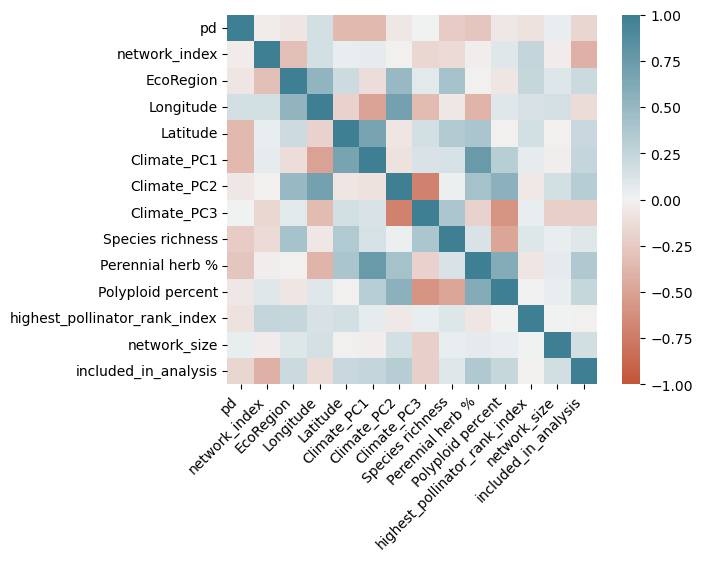

In [40]:
# do pairwise corrrelations test
all_corr = df[features].corr()

ax = sns.heatmap(
    all_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

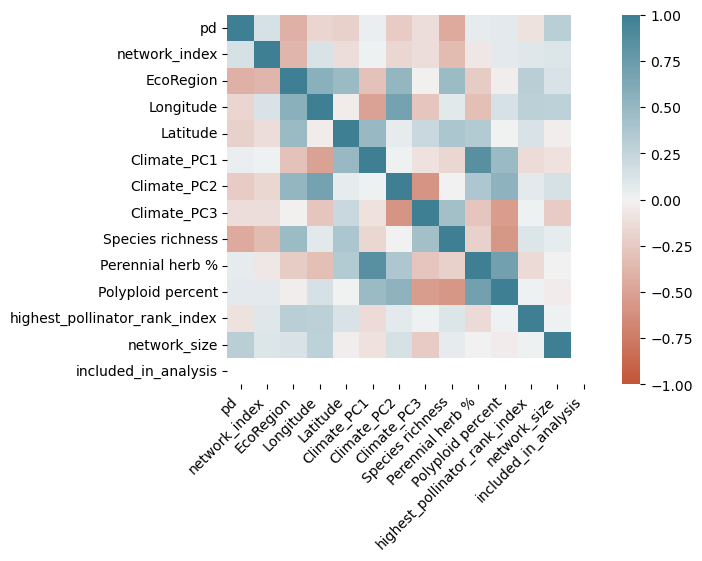

In [41]:
# do pairwise corrrelations test
an_corr = df.query("included_in_analysis")[features].corr()

ax = sns.heatmap(
    an_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

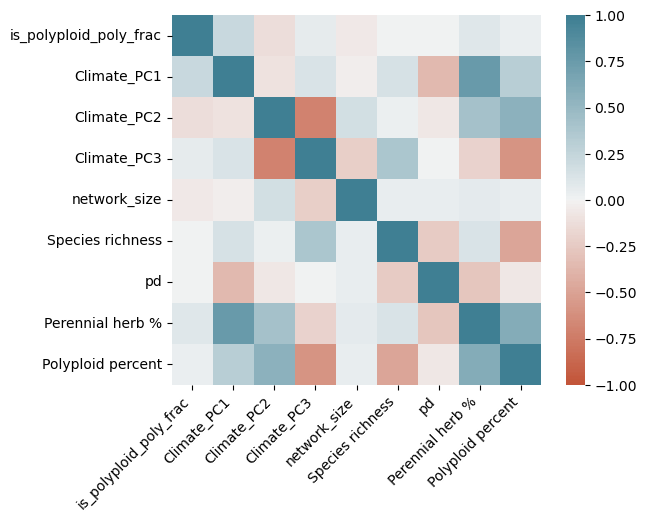

In [42]:
# do pairwise corrrelations test
all_corr_only_rel = df[rel_features].corr()

ax = sns.heatmap(
    all_corr_only_rel, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

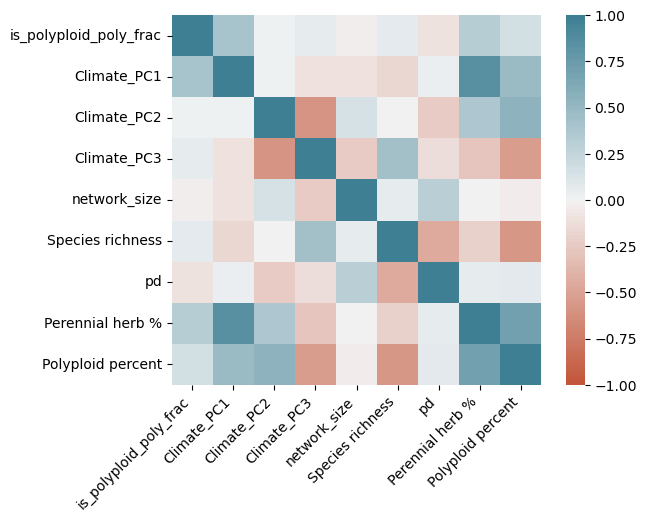

In [43]:
# do pairwise corrrelations test
an_corr_only_rel = df.query("included_in_analysis")[rel_features].corr()

ax = sns.heatmap(
    an_corr_only_rel, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [44]:
# report features with absolute correlation >= 0.9
high_corr_indices = np.where(np.abs(all_corr_only_rel) >= 0.9)
highly_corr_feautres = [(rel_features[high_corr_indices[0][i]],rel_features[high_corr_indices[1][i]]) for i in range(len(high_corr_indices[0])) if high_corr_indices[0][i] > high_corr_indices[1][i]]
print("highly correlated pairs of features: \n", '\n'.join([",".join(i) for i in highly_corr_feautres]))

highly correlated pairs of features: 
 


In [45]:
# report features with absolute correlation >= 0.9
high_corr_indices = np.where(np.abs(all_corr) >= 0.9)
highly_corr_feautres = [(features[high_corr_indices[0][i]],features[high_corr_indices[1][i]]) for i in range(len(high_corr_indices[0])) if high_corr_indices[0][i] > high_corr_indices[1][i]]
print("highly correlated pairs of features: \n", '\n'.join([",".join(i) for i in highly_corr_feautres]))

highly correlated pairs of features: 
 


In [46]:
df.query("included_in_analysis").drop_duplicates("network_id")[rel_features].notna().sum()

is_polyploid_poly_frac    272
Climate_PC1               232
Climate_PC2               232
Climate_PC3               232
network_size              272
Species richness          232
pd                        272
Perennial herb %          232
Polyploid percent         232
dtype: int64

In [47]:
df.query("included_in_analysis").sort_values("network_id").dropna(subset=rel_features)[["network_id"] + rel_features]

,network_id,is_polyploid_poly_frac,Climate_PC1,Climate_PC2,Climate_PC3,network_size,Species richness,pd,Perennial herb %,Polyploid percent
75,100_weighted,0.266667,1.094337,-2.414487,0.465549,836.0,7.652546,6.061906,-0.471186,35.363169
78,101_weighted,0.466667,1.094337,-2.414487,0.465549,851.0,7.652546,12.292062,-0.471186,35.363169
82,102_weighted,0.285714,1.094337,-2.414487,0.465549,1600.0,7.652546,9.521403,-0.471186,35.363169
80,103_weighted,0.210526,1.094337,-2.414487,0.465549,1020.0,7.652546,8.139938,-0.471186,35.363169
127,114_weighted,0.700000,4.049408,1.220679,0.452811,168.0,7.567346,8.973639,1.204943,44.107744
...,...,...,...,...,...,...,...,...,...,...
56,91_weighted,0.437500,4.049408,1.220679,0.452811,777.0,7.567346,5.922775,1.204943,44.107744
517,92_weighted,0.608696,3.586145,0.909314,0.390904,7280.0,7.394493,9.859952,1.253052,45.245902
66,97_weighted,0.461538,1.094337,-2.414487,0.465549,684.0,7.652546,4.984610,-0.471186,35.363169
69,98_weighted,0.250000,1.094337,-2.414487,0.465549,390.0,7.652546,7.862437,-0.471186,35.363169


In [48]:
df = pd.read_csv(processed_data_path)
df['included_in_analysis'] = df.parallel_apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and
                                               rec.num_classified > min_classified_threshold and
                                               rec.num_polyploids >= min_poly_threhold and
                                               rec.num_diploids >= min_di_threshold, axis=1)
                                            
df.query("included_in_analysis")[["is_polyploid_missing_frac","network_size","pd","Climate_PC1","Climate_PC2","Climate_PC3","Species richness","Perennial herb %","Polyploid percent","highest_pollinator_rank_index"]].notna().sum()

is_polyploid_missing_frac        272
network_size                     272
pd                               272
Climate_PC1                      232
Climate_PC2                      232
Climate_PC3                      232
Species richness                 232
Perennial herb %                 232
Polyploid percent                232
highest_pollinator_rank_index    272
dtype: int64